In [1]:
import tensorflow as tf
import tensorflow.keras as K
import pandas as pd
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import metrics


2024-06-21 07:15:47.869021: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-21 07:15:47.871974: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-21 07:15:47.914273: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-21 07:15:47.915563: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-21 07:15:48.650125: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT

In [2]:
vista = 'CC' ## 'CC' o 'MLO'

In [3]:
def preprocess_data(X, Y):
    """
    Pre-processes the data for the model
        - X is a numpy.ndarray of shape (m, 1024, 1024, 3) containing
         the mammography, where m is the number of data points
        - Y is a numpy.ndarray of shape (m,) containing
         the Bi-Rads labels for X
    Returns:
        - X_p is a numpy.ndarray containing the preprocessed X
        - Y_p is a numpy.ndarray containing the preprocessed Y
    """
    X_p = K.applications.densenet.preprocess_input(X)

    Y_p = K.utils.to_categorical(Y, 3)

    return X_p, Y_p

In [4]:
df_INbreast_train = pd.read_pickle('/workspace/container_0/andres/data/df_INbreast_train.pkl')
df_INbreast_val = pd.read_pickle('/workspace/container_0/andres/data/df_INbreast_val.pkl')

if vista == 'CC':
    df_INbreast_train = df_INbreast_train.drop(columns = ['MLO Image']).rename(columns = {'CC Image': 'Image'})
    df_INbreast_val = df_INbreast_val.drop(columns = ['MLO Image']).rename(columns = {'CC Image': 'Image'})
elif vista == 'MLO':
    df_INbreast_train = df_INbreast_train.drop(columns = ['CC Image']).rename(columns = {'MLO Image': 'Image'})
    df_INbreast_val = df_INbreast_val.drop(columns = ['CC Image']).rename(columns = {'MLO Image': 'Image'})

In [6]:
dict_valores = {'benigno': 0, 'seguimiento': 1, 'maligno': 2}
Y_traintest = np.array(df_INbreast_train['Bi-Rads'].map(dict_valores).tolist())
X_traintest = np.array(df_INbreast_train['Image'].tolist())
Y_val = np.array(df_INbreast_val['Bi-Rads'].map(dict_valores).tolist())
X_val = np.array(df_INbreast_val['Image'].tolist())
X_val, Y_val = preprocess_data(X_val, Y_val)
del df_INbreast_train
del df_INbreast_val

In [7]:
def DenseNet169_1Rama(vista, input_dim = 512, rand_seed = 13, learning_rate = 0.0001, momentum = 0.9):
    """
    Define the DenseNet architecture and compile the model
        - vista is a mammogram view we want to train
        - input_dim is the size of the mammogram in pixels
        - rand_seed is a random seed number used during the fc layer initialization
        - learning_rate is the learning rate used during the training
        - momentum is the parameters that defines the momentun for the SGD optimizer
    Returns:
        - model_1rama is the output compiled DenseNet model
    """
    # Definimos la architectura del modelo
    densenet = K.applications.DenseNet169(
        include_top = False,
        weights = "imagenet",
        input_tensor = None,
        input_shape = (256, 256, 3),
        pooling = 'avg'
    )

    densenet.trainable = True

    # Entrenaremos solo el bloque de capas conv5, las demas las dejamos con los pesos preestablecidos de la DenseNet121
    for layer in densenet.layers:
        if 'conv5' in layer.name:
            layer.trainable = True
        else:
            layer.trainable = False

    # Deefinimos el tamaño de las imágenes de entrada.
    input_img = K.Input(shape = (input_dim, input_dim, 3))
    # Lambda que ajustará la imagenes a un tamaño de  256x256
    preprocess = K.layers.Lambda(lambda x: tf.image.resize(x, (256, 256)), name = 'resize_' + vista)(input_img)

    initializer = K.initializers.he_normal(seed = rand_seed)

    fc_layer = densenet(inputs = preprocess)

    fc_layer = K.layers.Dense(units = 3,
                              activation = 'softmax',
                              kernel_initializer = initializer
                              )(fc_layer)

    model_1rama = K.models.Model(inputs = input_img, outputs = fc_layer)

    # Compile the model
    opt = K.optimizers.SGD(learning_rate = learning_rate, momentum = momentum)

    model_1rama.compile(loss = 'categorical_crossentropy',
                        optimizer = opt,
                        metrics = ['accuracy'])

    return model_1rama

In [8]:
DenseNet169_1Rama(vista).summary()

2024-06-21 07:15:55.259983: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-21 07:15:55.260832: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


51877672/51877672 [==============================] - 2s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 512, 512, 3)]     0         
                                                                 
 resize_CC (Lambda)          (None, 256, 256, 3)       0         
                                                                 
 densenet169 (Functional)    (None, 1664)              12642880  
                                                                 
 dense (Dense)               (None, 3)                 4995      
                                                                 
Total params: 12647875 (48.25 MB)
Trainable params: 5918595 (22.58 MB)
Non-trainable params: 6729280 (25.67 MB)
_________________________________________________________________


In [9]:
def part_traintest(X_traintest, Y_traintest, rand_seed = 13, frac_test = .2/.8):
    """
    Function that makes a partition for training and testing from the original dataset
        - X_traintest is the array of images from the original dataset
        - Y_traintest is the array of labels from the original dataset
        - rand_seed is a random seed number used during the sampling
        - frac_test is the fraction of cases used in the test subset
    Returns:
        - X_train is the train array of images
        - Y_train is the train array of labels
        - X_test is the test array of images
        - Y_test is the test array of labels
    """
    np.random.seed(rand_seed)
    index_test = np.array([], dtype = 'int')

    for i in np.unique(Y_traintest):
        index_test = np.append(index_test,
                               np.random.choice(list(np.where(Y_traintest == i)[0]), size = int(np.where(Y_traintest == i)[0].shape[0]*frac_test), replace = False))

    index_test = [int(x) for x in index_test]
    print(index_test)
    X_train = np.delete(X_traintest, index_test, axis = 0)

    Y_train = np.delete(Y_traintest, index_test)
    X_test = np.take(X_traintest, index_test, axis = 0)
    Y_test = np.take(Y_traintest, index_test)
#     print(X_train)
#     print(Y_train)
#     print(Y_traintest)
    X_train, Y_train = preprocess_data(X_train, Y_train)
    X_test, Y_test = preprocess_data(X_test, Y_test)


    return X_train, Y_train, X_test, Y_test

In [10]:
batch_size = 16
no_epochs = 300
input_dim = X_traintest.shape[1]
rand_seed = 2021
n_folds = 3
frac_test = .2/.8

In [11]:
label, counts = np.unique(Y_traintest, return_counts = True)
class_weight = {}
for lab, con in zip(label, counts):
  class_weight.update({lab: round(max(counts)/con, 2)})

In [12]:
early_stopping = EarlyStopping(patience = 20, restore_best_weights = True)
reduce_lr = ReduceLROnPlateau(factor = 0.5, patience = 5)

In [13]:
learn_rate = [0.01, 0.001, 0.0001]
momentum = [0, 0.5, 0.9]

tot_comb = len(learn_rate) * len(momentum)
glob_param = np.empty([tot_comb, 2])

history_list = []
scores_glob_array = np.empty([tot_comb, n_folds, 2])

import itertools

for idx, x in enumerate(itertools.product(learn_rate, momentum)):
    learn_rate = x[0]
    momentum = x[1]

    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for combination {idx + 1}/{tot_comb} ...')
    print(f'Learning rate = {learn_rate}')
    print(f'Momentum = {momentum}')
    print('------------------------------------------------------------------------')

    history_array = np.array([])
    scores_array = np.empty([n_folds, 2])

    glob_param[idx, 0] = learn_rate
    glob_param[idx, 1] = momentum

    for fold in range(n_folds):
        # Generate a print
        print('------------------------------------------------------------------------')
        print(f'Training for fold {fold + 1}/{n_folds} ...')
        print('------------------------------------------------------------------------')

        # Generate the fold sample for train-test
        X_train, Y_train, X_test, Y_test = part_traintest(X_traintest, Y_traintest, rand_seed + fold, frac_test)

        # Define the model architecture
        model_1rama = DenseNet169_1Rama(vista, input_dim, rand_seed, learn_rate, momentum)

        # Fit data to model
        history = model_1rama.fit(X_train, Y_train,
                                  batch_size = batch_size,
                                  epochs = no_epochs,
                                  validation_data = (X_test, Y_test),
                                  class_weight = class_weight,
                                  verbose = 1,
                                  callbacks = [early_stopping, reduce_lr])

        # Generate generalization metrics
        scores_array[fold, :] = model_1rama.evaluate(X_val, Y_val, verbose = 0)
        print('------------------------------------------------------------------------')
        print(f'Score for fold {fold + 1}: {model_1rama.metrics_names[0]} of {round(scores_array[fold, 0], 2)}; {model_1rama.metrics_names[1]} of {round(scores_array[fold, 1]*100, 2)}%')
        print('------------------------------------------------------------------------')
        print('')

        # Append history callback into array
        history_array = np.append(history_array, [history])

    # == Provide average scores ==
    print('------------------------------------------------------------------------')
    print('Score per fold')
    for i in range(0, scores_array.shape[0]):
        print('------------------------------------------------------------------------')
        print(f'> Fold {i + 1} - Loss: {round(scores_array[i, 0], 2)} - Accuracy: {round(scores_array[i, 1], 2)}%')
    print('------------------------------------------------------------------------')
    print(f'Average scores for all folds (LR = {learn_rate}, mtm = {momentum}):')
    print(f'> Accuracy: {round(np.mean(scores_array[:, 1]), 2)} (+- {round(np.std(scores_array[:, 1]), 2)})')
    print(f'> Loss: {round(np.mean(scores_array[:, 0]), 2)} (+- {round(np.std(scores_array[:, 0]), 2)})')
    print('------------------------------------------------------------------------')
    print('')
    print('')

    idx_best_hist = np.argmax(scores_array[:, 1])
    history_list.append(history_array[idx_best_hist])

    scores_glob_array[idx, :, :] = scores_array

------------------------------------------------------------------------
Training for combination 1/9 ...
Learning rate = 0.01
Momentum = 0
------------------------------------------------------------------------
------------------------------------------------------------------------
Training for fold 1/3 ...
------------------------------------------------------------------------
[21, 60, 9, 48, 31, 16, 47, 51, 143, 69, 116, 83, 38, 67, 41, 11, 85, 144, 63, 156, 115, 126, 119, 153, 102, 113, 147, 106, 159, 7, 187, 185, 196, 186, 201, 206, 179, 175, 111, 164, 160, 182, 71, 138, 66, 50, 1, 205, 45, 53, 62, 105]
Epoch 1/300
10/10 [==============================] - 24s 2s/step - loss: 2.2195 - accuracy: 0.4051 - val_loss: 1.8560 - val_accuracy: 0.0769 - lr: 0.0100
Epoch 2/300
10/10 [==============================] - 14s 1s/step - loss: 1.5149 - accuracy: 0.4684 - val_loss: 0.9343 - val_accuracy: 0.3846 - lr: 0.0100
Epoch 3/300
10/10 [==============================] - 14s 1s/step - loss: 

In [14]:
def plot_metrics(history):
    """
    Function that plots the metrics from the training process
        - history is the output from the training process
    """
    fig = plt.figure(figsize = (15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc = 'upper left')
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc = 'upper right')
    
    plt.show()
    return

def print_cm(cm, labels, hide_zeroes=False, hide_diagonal=False, hide_threshold=None):
    """
    Credit to:
    https://gist.github.com/zachguo/10296432
    
    Function that makes a pretty print for confusion matrixes
        - cm is the array of histories generated during the training process
        - labels is number of epochs fixed for the training process
        - hide_zeroes is a boolean that allows the user to hide the zeroes in the matrix
        - hide_diagonal is a boolean that allows the user to hide the diagonal in the matrix
        - hide_threshold is a number that allows the user to hide results in the matrix below that value
    """
    columnwidth = max([len(x) for x in labels] + [5])  # 5 is value length
    empty_cell = " " * columnwidth
    # Print header
    print("    " + empty_cell, end=" ")
    for label in labels:
        print("%{0}s".format(columnwidth) % label, end=" ")
    print()
    # Print rows
    for i, label1 in enumerate(labels):
        print("    %{0}s".format(columnwidth) % label1, end=" ")
        for j in range(len(labels)):
            cell = "%{0}.1f".format(columnwidth) % cm[i, j]
            if hide_zeroes:
                cell = cell if float(cm[i, j]) != 0 else empty_cell
            if hide_diagonal:
                cell = cell if i != j else empty_cell
            if hide_threshold:
                cell = cell if cm[i, j] > hide_threshold else empty_cell
            print(cell, end=" ")
        print()
    return

In [15]:
print(f'Resultados promedios del entrenamiento DenseNet-{vista}:')
for i in range(len(glob_param)):
    print(f'- LR={glob_param[i, 0]} / mom={glob_param[i, 1]}:\tAcc={round(np.mean(scores_glob_array[i, :, 1]), 2)} (+- {round(np.std(scores_glob_array[i, :, 1]), 2)}) - Loss={round(np.mean(scores_glob_array[i, :, 0]), 2)} (+- {round(np.std(scores_glob_array[i, :, 0]), 2)})')

idx_best = np.argmax(np.mean(scores_glob_array, 1)[:, 1])
history_best = history_list[idx_best]
model_best = history_best.model
print(f'\nEl mejor resultado para la DenseNet-{vista} se obtiene para LR = {glob_param[idx_best, 0]} y momentum = {glob_param[idx_best, 1]}.')

Resultados promedios del entrenamiento DenseNet-CC:
- LR=0.01 / mom=0.0:	Acc=0.65 (+- 0.02) - Loss=0.83 (+- 0.01)
- LR=0.01 / mom=0.5:	Acc=0.65 (+- 0.01) - Loss=0.81 (+- 0.02)
- LR=0.01 / mom=0.9:	Acc=0.27 (+- 0.14) - Loss=1.27 (+- 0.14)
- LR=0.001 / mom=0.0:	Acc=0.7 (+- 0.05) - Loss=0.73 (+- 0.04)
- LR=0.001 / mom=0.5:	Acc=0.67 (+- 0.05) - Loss=0.78 (+- 0.06)
- LR=0.001 / mom=0.9:	Acc=0.71 (+- 0.02) - Loss=0.74 (+- 0.07)
- LR=0.0001 / mom=0.0:	Acc=0.69 (+- 0.04) - Loss=0.74 (+- 0.02)
- LR=0.0001 / mom=0.5:	Acc=0.68 (+- 0.04) - Loss=0.73 (+- 0.02)
- LR=0.0001 / mom=0.9:	Acc=0.71 (+- 0.03) - Loss=0.73 (+- 0.03)

El mejor resultado para la DenseNet-CC se obtiene para LR = 0.001 y momentum = 0.9.


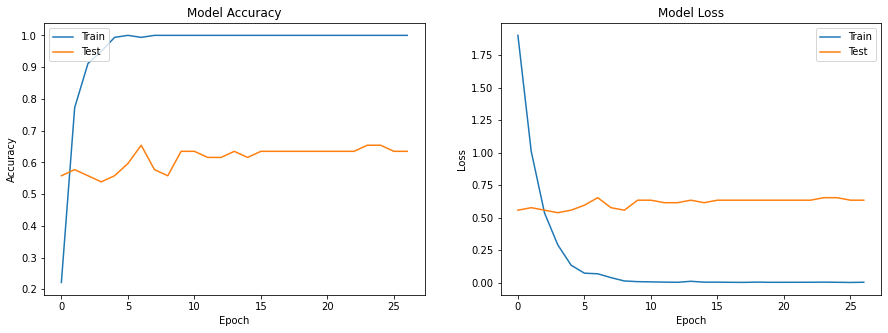

In [16]:
plot_metrics(history_best)

In [17]:
conf_matrix = metrics.confusion_matrix(Y_val.argmax(axis = 1), model_best.predict(X_val).argmax(axis = 1))
print_cm(conf_matrix, list(dict_valores.keys()))

2/2 [==============================] - 4s 897ms/step
                    benigno seguimiento     maligno 
        benigno        27.0         0.0         1.0 
    seguimiento         3.0         0.0         1.0 
        maligno         9.0         0.0        11.0 


In [18]:
classif_report = metrics.classification_report(Y_val.argmax(axis = 1), model_best.predict(X_val).argmax(axis = 1),
                                               target_names = list(dict_valores.keys()))
print(classif_report)

2/2 [==============================] - 2s 974ms/step
              precision    recall  f1-score   support

     benigno       0.69      0.96      0.81        28
 seguimiento       0.00      0.00      0.00         4
     maligno       0.85      0.55      0.67        20

    accuracy                           0.73        52
   macro avg       0.51      0.50      0.49        52
weighted avg       0.70      0.73      0.69        52



/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [19]:
file_path = './model_best_DN169_ft_' + vista
K.models.save_model(model_best, file_path)

INFO:tensorflow:Assets written to: ./model_best_DN169_ft_CC/assets


INFO:tensorflow:Assets written to: ./model_best_DN169_ft_CC/assets
